# Weather Guess

### COhPy Challenge Issued Mar, 2016

> Andrew Kubera

# Part One

### Given a month, return list of dates in that month that COhPy has met 

Use the powerful **`dateutil`** module. This gives us a great `relativedelta` class which allows specifying things such as "last monday of month"

In [1]:
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse as parse_datetime

# days of the week constants
from dateutil.rrule import MO, TU, WE, TH, FR, SA, SU

from datetime import *

In [2]:
class DateFinder:
    
    EPOCH = parse_datetime('September 28, 2009')
    
    # jump to last day (31 for all months) then backtrack to previous monday 
    LAST_MONDAY_OF_MONTH = relativedelta(day=31, weekday=MO(-1))
    
    # a special case for May - second to last monday of month
    SECOND_TO_LAST_MONDAY_OF_MONTH = relativedelta(day=31, weekday=MO(-2))
    
    # jump back one year
    PREVIOUS_YEAR = relativedelta(years=-1)
    
    def __init__(self, monthname):
        """
        Create the finder from the name of a month.
        :param monthname (str): Long or short name of a month (English).
        """
        start_date = parse_datetime(monthname) 
        delta_rule = self.delta_rule_for_month(start_date.month)
        start_date += delta_rule
        if start_date > datetime.today():
            start_date += self.PREVIOUS_YEAR + delta_rule

        self.month = start_date.month
        self.start = start_date
        self.delta = delta_rule

    @staticmethod
    def delta_rule_for_month(month):
        # special November case
        if month == 11:
            return relativedelta(year=1970)

        # special December case - find first monday after the 3rd
        elif month == 12:
            return relativedelta(day=3, weekday=MO(1))

        # sepcial May case - second to last monday
        elif month == 5:
            return DateFinder.SECOND_TO_LAST_MONDAY_OF_MONTH

        # general case
        else:
            return DateFinder.LAST_MONDAY_OF_MONTH

    def __iter__(self):
        # loop until we go past the 'EPOCH' date
        n = self.start
        while n >= self.EPOCH:
            yield n
            n += relativedelta(years=-1) + self.delta

    def __str__(self):
        return ', '.join(map(lambda dt: dt.strftime("%m/%d/%Y"), self))

In [3]:
list(DateFinder('Jan'))

[datetime.datetime(2016, 1, 25, 0, 0),
 datetime.datetime(2015, 1, 26, 0, 0),
 datetime.datetime(2014, 1, 27, 0, 0),
 datetime.datetime(2013, 1, 28, 0, 0),
 datetime.datetime(2012, 1, 30, 0, 0),
 datetime.datetime(2011, 1, 31, 0, 0),
 datetime.datetime(2010, 1, 25, 0, 0)]

In [4]:
months = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()

print("\n".join("%s: %s" % (mo, DateFinder(mo)) for mo in months))

Jan: 01/25/2016, 01/26/2015, 01/27/2014, 01/28/2013, 01/30/2012, 01/31/2011, 01/25/2010
Feb: 02/29/2016, 02/23/2015, 02/24/2014, 02/25/2013, 02/27/2012, 02/28/2011, 02/22/2010
Mar: 03/28/2016, 03/30/2015, 03/31/2014, 03/25/2013, 03/26/2012, 03/28/2011, 03/29/2010
Apr: 04/25/2016, 04/27/2015, 04/28/2014, 04/29/2013, 04/30/2012, 04/25/2011, 04/26/2010
May: 05/18/2015, 05/19/2014, 05/20/2013, 05/21/2012, 05/23/2011, 05/24/2010
Jun: 06/29/2015, 06/30/2014, 06/24/2013, 06/25/2012, 06/27/2011, 06/28/2010
Jul: 07/27/2015, 07/28/2014, 07/29/2013, 07/30/2012, 07/25/2011, 07/26/2010
Aug: 08/31/2015, 08/25/2014, 08/26/2013, 08/27/2012, 08/29/2011, 08/30/2010
Sep: 09/28/2015, 09/29/2014, 09/30/2013, 09/24/2012, 09/26/2011, 09/27/2010, 09/28/2009
Oct: 10/26/2015, 10/27/2014, 10/28/2013, 10/29/2012, 10/31/2011, 10/25/2010, 10/26/2009
Nov: 
Dec: 12/07/2015, 12/08/2014, 12/09/2013, 12/03/2012, 12/05/2011, 12/06/2010, 12/07/2009


# Part Two

### Given a set of dates (particularly the dates returned in Part One), return the high temperature in Columbus, Ohio at the airport (weather station KCMH) for each of those dates.

I used NOAA daily climate data for all days between 2009-2016, imported as a csv file from their website.

To load the csv, let's use pandas!

In [26]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [337]:
weather_data = pd.read_csv("weather-data.csv")
"Loaded %d days of data" % len(weather_data)

'Loaded 2667 days of data'

In [319]:
weather_data.head()

,STATION,STATION_NAME,DATE,PRCP,SNWD,SNOW,TMAX,TMIN,WESD,AWND,...,WT02,WT11,WT22,WT04,WT13,WT16,WT08,WT18,WT03,WT19
0,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,20090101,0.00,0.0,0.0,33,18,0.0,7.61,...,-9999,-9999,-9999,-9999,-9999,1,-9999,1,-9999,-9999
1,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,20090102,0.00,0.0,0.0,44,29,0.0,11.18,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,20090103,0.00,0.0,0.0,42,21,0.0,5.59,...,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999,-9999
3,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,20090104,0.14,0.0,0.0,50,33,0.0,7.61,...,1,-9999,-9999,-9999,1,1,1,-9999,-9999,-9999
4,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,20090105,0.00,0.0,0.0,35,27,0.0,6.26,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999


This dataset uses the value -9999 to indicate no value, replace this with numpy's nan. Normalize datetime string to actual datetime objects, and use it as the index.

In [320]:
weather_data.index

RangeIndex(start=0, stop=2667, step=1)

In [ ]:
weather_data.DATE = weather_data.DATE.apply(lambda x: parse_datetime(str(x)))
weather_data[weather_data == -9999] = np.nan
weather_data.set_index(['DATE'])

In [322]:
weather_data = pd.read_csv("weather-data.csv", parse_dates={'date': ['DATE']}, index_col='date')
"Loaded %d days of data" % len(weather_data)

'Loaded 2667 days of data'

In [323]:
weather_data.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2016-04-11', '2016-04-12', '2016-04-13', '2016-04-14',
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20'],
              dtype='datetime64[ns]', name='date', length=2667, freq=None)

In [343]:
def get_temp(a_date):
    if isinstance(a_date, str):
        a_date = parse_datetime(a_date).date()
    tmp = weather_data[weather_data.DATE == a_date].TMAX
    try:
        return float(tmp)
    except TypeError:
        if tmp.empty:
            return None


In [344]:
get_temp("Jan 5, 2010")

22.0

In [345]:
for april_date in DateFinder("april"):
    tmp = get_temp(april_date)
    print(april_date.date(), "~", tmp)

2016-04-25 ~ None
2015-04-27 ~ 54.0
2014-04-28 ~ 59.0
2013-04-29 ~ 65.0
2012-04-30 ~ 84.0
2011-04-25 ~ 74.0
2010-04-26 ~ 57.0


In [350]:
for month in months:
    print("%s:" % month)
    for next_date in DateFinder(month):
        tmp = get_temp(next_date)
        if tmp:
            print("\t%s ~ %.1f" % (next_date.date(), tmp))

Jan:
	2016-01-25 ~ 46.0
	2015-01-26 ~ 27.0
	2014-01-27 ~ 42.0
	2013-01-28 ~ 51.0
	2012-01-30 ~ 50.0
	2011-01-31 ~ 32.0
	2010-01-25 ~ 49.0
Feb:
	2016-02-29 ~ 57.0
	2015-02-23 ~ 19.0
	2014-02-24 ~ 34.0
	2013-02-25 ~ 46.0
	2012-02-27 ~ 58.0
	2011-02-28 ~ 63.0
	2010-02-22 ~ 40.0
Mar:
	2016-03-28 ~ 59.0
	2015-03-30 ~ 57.0
	2014-03-31 ~ 65.0
	2013-03-25 ~ 36.0
	2012-03-26 ~ 52.0
	2011-03-28 ~ 42.0
	2010-03-29 ~ 50.0
Apr:
	2015-04-27 ~ 54.0
	2014-04-28 ~ 59.0
	2013-04-29 ~ 65.0
	2012-04-30 ~ 84.0
	2011-04-25 ~ 74.0
	2010-04-26 ~ 57.0
May:
	2015-05-18 ~ 79.0
	2014-05-19 ~ 71.0
	2013-05-20 ~ 86.0
	2012-05-21 ~ 87.0
	2011-05-23 ~ 82.0
	2010-05-24 ~ 83.0
Jun:
	2015-06-29 ~ 66.0
	2014-06-30 ~ 87.0
	2013-06-24 ~ 87.0
	2012-06-25 ~ 80.0
	2011-06-27 ~ 83.0
	2010-06-28 ~ 85.0
Jul:
	2015-07-27 ~ 87.0
	2014-07-28 ~ 76.0
	2013-07-29 ~ 76.0
	2012-07-30 ~ 90.0
	2011-07-25 ~ 89.0
	2010-07-26 ~ 83.0
Aug:
	2015-08-31 ~ 86.0
	2014-08-25 ~ 87.0
	2013-08-26 ~ 90.0
	2012-08-27 ~ 84.0
	2011-08-29 ~ 78.0
	2010-08-3

# END HERE

In [13]:
def get_pytemps(month_name):
    """Return the date, temperature pairs in for cohpy meetins in given month"""
    for next_date in DateFinder(month_name):
        yield next_date.date(), get_temp(next_date)

In [14]:
list(get_pytemps("jan"))

[(datetime.date(2016, 1, 25), 46.0),
 (datetime.date(2015, 1, 26), 27.0),
 (datetime.date(2014, 1, 27), 42.0),
 (datetime.date(2013, 1, 28), 51.0),
 (datetime.date(2012, 1, 30), 50.0),
 (datetime.date(2011, 1, 31), 32.0),
 (datetime.date(2010, 1, 25), 49.0)]

# Part Three

### Predict the temperature of the 2016 May COhPy meeting

In [136]:
import lmfit
from operator import attrgetter


Due to time constraints, I will just use max temperatures in my prediction formula.

#### Method:
   * Use weighted average of previous year's temperatures to predict future temperature.


   
   generate a 'prediction vector' that, when multiplied by vector of previous temperatures, predicts the next.

prediction vector:
$$\vec{\alpha} = \alpha_1, \alpha_2, ... \alpha_n$$

temperature vector:
$$\vec{\tau} = \tau_1, \tau_2, \cdots, \tau_n$$
where
$$ \tau_1 \equiv \text{temp}_\text{yesterday} \\
   \tau_2 \equiv temp_\text{2 days ago}\\
   \tau_n = temp_\text{n days ago}$$

In [333]:
def temp_from_day(date):
    date = parse_datetime(date) if isinstance(date, str) else date
    return weather_data.TMAX[weather_data.DATE == date.date()]

In [270]:
x = np.ones(6)
y = np.zeros(8)

In [272]:
DATE_WIDTH = 16
DATE_WIDTH_LEN = 2 * DATE_WIDTH - 1

def prev_year_data(date):
    date = parse_datetime(date) if isinstance(date, str) else date
    date = date.date() - timedelta(365)
    
    delta = timedelta(DATE_WIDTH)
    
    mask = (date - delta < weather_data.DATE) & (weather_data.DATE < date + delta)
    return np.array(weather_data.TMAX[mask], dtype=float)

DEFAULT_GUESS = np.ones(DATE_WIDTH_LEN)
DEFAULT_GUESS[DATE_WIDTH] = 1


In [273]:
tmp_params = lmfit.Parameters()
for i, v in enumerate(DEFAULT_GUESS):
    tmp_params.add("alpha_%d" % i, value=v)

In [274]:
def fit_temps(p, temps, expected=None):
    alpha = np.array(list(v.value for k, v in p.items() if k.startswith("alpha")))
    if np.ndim(temps) > 1:
        model = [np.average(alpha * t) for t in temps]
    else:
        model = np.average(alpha * temps) 
    if expected is not None:
        return expected - model
    return float(model)

In [289]:
start_date = parse_datetime('May 1, 2015')

expected_temperatures = []
past_temperatures = []

for i in range(DATE_WIDTH * 3):
    date = start_date + timedelta(i)
    expected_temperatures.append(float(temp_from_day(date)))
    past_temperatures.append(prev_year_data(date))

expected_temperatures = np.array(expected_temperatures)
past_temperatures = np.array(past_temperatures)

In [290]:
fit = lmfit.minimize(fit_temps, tmp_params, args=(past_temperatures, expected_temperatures))

In [299]:
fit.chisqr / (fit.ndata - fit.nvarys)
# lmfit.report_fit(fit)

87.331843632601959

In [294]:
temp_from_day('May 22, 2011'), fit_temps(fit.params, prev_year_data('May 22, 2011'))
# np.ndim(prev_year_data('may 22, 2016'))
# past_temperatures

(85.0, 90.02999303210876)

In [293]:
fit_temps(fit.params, prev_year_data('May 23, 2016'))


84.62561480900477

In [303]:
def test_data_for(date):
    date = parse_datetime(date) if isinstance(date, str) else date
    return weather_data.index[date.date()]
test_data_for("april 1, 2016")

TypeError: int() argument must be a string, a bytes-like object or a number, not 'datetime.date'

In [304]:
weather_data.head()

,STATION,STATION_NAME,DATE,PRCP,SNWD,SNOW,TMAX,TMIN,WESD,AWND,...,WT02,WT11,WT22,WT04,WT13,WT16,WT08,WT18,WT03,WT19
0,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,2009-01-01,0.00,0.0,0.0,33,18,0.0,7.61,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
1,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,2009-01-02,0.00,0.0,0.0,44,29,0.0,11.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,2009-01-03,0.00,0.0,0.0,42,21,0.0,5.59,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,2009-01-04,0.14,0.0,0.0,50,33,0.0,7.61,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
4,GHCND:USW00014821,COLUMBUS PORT COLUMBUS INTERNATIONAL AIRPORT O...,2009-01-05,0.00,0.0,0.0,35,27,0.0,6.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To use as much of the data as we can, I will use scikit.learn to find correlations for me

In [15]:
from sklearn.tree import DecisionTreeRegressor

In [16]:
?DecisionTreeRegressor

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

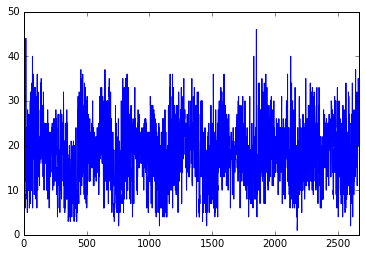

In [28]:
(weather_data.TMAX - weather_data.TMIN).plot()

In [30]:
sp = np.fftd .fft (weather_data.TMAX)


In [22]:
%matplotlib inline
plt.show()

In [34]:
sp = np.fft.fft(weather_data.TMAX)
freq = np.fft.fftfreq(weather_data.TMAX.shape[-1])

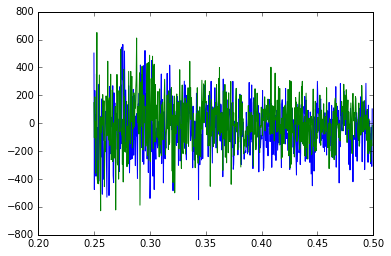

In [40]:
subset = slice(666, 1332)
plt.plot(freq[subset], sp.real[subset], freq[subset], sp.imag[subset])

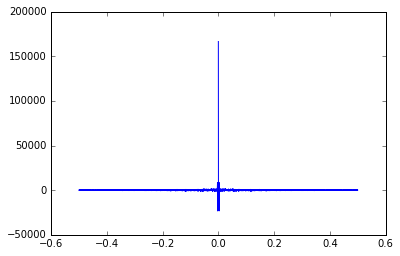

In [42]:
plt.plot(freq, sp.real)

In [39]:
len(sp.real), len(freq)

(2667, 2667)

In [69]:
weather_data.DATE[1000]

Timestamp('2011-09-28 00:00:00')

In [43]:
type(sp.real)

numpy.ndarray

In [46]:
fft_df = pd.DataFrame(dict(freq=freq, real=sp.real, imag=sp.imag))

In [49]:
max_temps = weather_data.TMAX

In [52]:
import lmfit

In [56]:
N = 4

In [67]:
p = 1000
tmp = max_temps[p-N:p]
max_temps[p]

65

In [70]:
weather_data.DATE[1000-365]

Timestamp('2010-09-28 00:00:00')